# Trabalho final - Introdução à Ciência de Dados

Nesse trabalho, foi solicitado que seja utilizada a metodologia OSEMN(Obtain, Scrub, Explore, Model and iNterpret) para tratar a base de dados da competição do Kaggle Telco Costumer Churn e obter insights sobre ela. 

## Etapa 0 - Importação de bibliotecas e funções auxiliares

In [123]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from itertools import product
from string import capwords
from IPython.core.display import HTML

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [21]:
#Script para centralizar os gráficos produzidos

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [22]:
#funções auxiliares

def estatisticas(df):
    d = df.describe(include='all')
    d.loc['skewness'] = skew(df)
    d.loc['kurtosis'] = kurtosis(df)
    
    return d

## Etapa 1 - Obtain/Obtenção

Nesse caso em específico, a obtenção é simples, pois basta carregar a base de dados já fornecida na competição. Em contextos reais, é comum precisar realizar *web scraping*, que consiste em uma raspagem/coleta dos dados brutos diretamente de algum site. ou outra fonte

In [3]:
# Pegando o caminho absoluto dos dados
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = ROOT_DIR + '\data\churn.csv'

df = pd.read_csv(DATA_DIR)

In [4]:
# Visão geral da base de dados
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Etapa 2 - Scrub/Limpeza

In [5]:
# Visão geral sobre os tipos de dados de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Aqui, já podemos observar alguns pontos que merecem uma atenção:

1. A coluna 'SeniorCitizen' apresenta tipo **int64**. Apesar de ser marcada com 1 e 0, é uma variável categórica.
2. A coluna 'TotalCharges' apresenta tipo **object**, geralmente utilizado para *strings*, mas é uma variável numérica.

Vamos investigar esses problemas.

Em primeira instância, podemos excluir a coluna de identificação do usuário, que não irá nos trazer informação relevante para esse problema.

In [6]:
df.drop('customerID', axis=1, inplace=True)

In [7]:
#Mudando o tipo de dados da coluna SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [8]:
#investigando os valores presentes na coluna TotalCharges
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

Como podemos ver, existem 11 registros com o caractere vazio ' '. 

Isso é um ocorrido comum em problemas reais. Nem sempre um dado faltante está representado como o tipo NaN, que seria o ideal. Podemos encontrá-lo como um caractere como '-', '.', '?', e outros, por isso é importante se atentar a esses detalhes.

In [9]:
#substituindo o caractere ' '(vazio) pelo tipo Not a Number do python e transformando a coluna para o tipo esperado.
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN).astype('float64')

Uma boa prática também é checar se há registros duplicados na base.

In [10]:
print(f'Há {sum(df.duplicated())} registros duplicados na base')

Há 22 registros duplicados na base


Como representam uma quantidade pequena, também iremos exclui-los.

In [11]:
df.drop_duplicates(inplace=True)

Por fim, iremos tratar os dados faltantes encontrados. Como a quantidade de dados faltantes representa aproximadamente $\frac{11}{7043}$ = 0,1% da nossa base, optamos por excluí-los.

In [12]:
df.dropna(inplace=True)

Agora, checamos novamente a informação geral dos dados para verificar se os problemas encontrados foram corrigidos.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7010 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   object 
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 


Podemos ver que foram excluídos os registros com dados faltantes e os tipos de dados também foram corrigidos. Como não foram encontradas mais inconsistências na base de dados, podemos prosseguir para a próxima etapa.

## Etapa 3 - Explore/Exploração

Na etapa de exploração, são realizadas verificações estatísticas sobre os dados para que haja a formulação de hipóteses sobre eles.

In [14]:
#variáveis numéricas
numericas = df.select_dtypes(include = np.number).columns.tolist()

#variáveis categóricas, excluindo a coluna target do nosso problema
categoricas = df.drop('Churn', axis = 1).select_dtypes(include = object).columns.tolist()

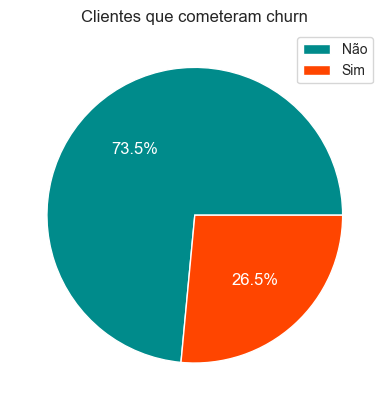

In [20]:
#Checando a distribuição da variável alvo

plt.pie(x = df['Churn'].value_counts(), 
        labels = ['Não', 'Sim'], 
        colors = ['darkcyan', 'orangered'], 
        autopct='%1.1f%%', 
        textprops={'color':"w", 'fontsize': 12})

plt.title('Clientes que cometeram churn')
plt.legend()

plt.show()

Como podemos notar, existe um certo **desbalanceamento nos dados**, como esperado nessa situação de Churn. Os clientes que realizaram Churn representam cerca de 26,5% da amostra. Não é um desbalanceamento exageradamente acentuado, mas ainda é algo que podemos dar atenção. Será explorado na etapa 4.

### 3.1. Variáveis numéricas

In [16]:
# Visão geral de estatísticas básicas sobre os dados

estatisticas(df[numericas])

,tenure,MonthlyCharges,TotalCharges
count,7010.000000,7010.000000,7010.000000
mean,32.520399,64.888666,2290.353388
std,24.520441,30.064769,2266.820832
min,1.000000,18.250000,18.800000
25%,9.000000,35.750000,408.312500
50%,29.000000,70.400000,1403.875000
75%,56.000000,89.900000,3807.837500
max,72.000000,118.750000,8684.800000
skewness,0.233690,-0.225638,0.958117
kurtosis,-1.388391,-1.252806,-0.239059


Através das estatísticas _skewness_ (assimetria) e _kurtosis_ (curtose) podemos chegar às seguintes conclusões:

**Sobre assimetria**:
- As variáveis tenure e TotalCharges apresentam uma assimetria **positiva**, ou seja, os dados estão um pouco mais concentrados **abaixo** da média, mas em TotalCharges isso é mais acentuado..
- A variável MonthlyCharges apresenta uma assimetria **negativa**, ou seja, os dados estão um pouco mais concentrados **acima** da média.

**Sobre curtose**:
- Ambas as variáveis apresentam um valor de curtose **menor que 3**, ou seja, a curva da distribuição é mais "achatada". Isso significa que os dados estão bem distribuídos. Porém, na variável TotalCharges, isso é mais suave.

Podemos comprovar as informações levantadas mostrando os gráficos de distribuição para cada variável.

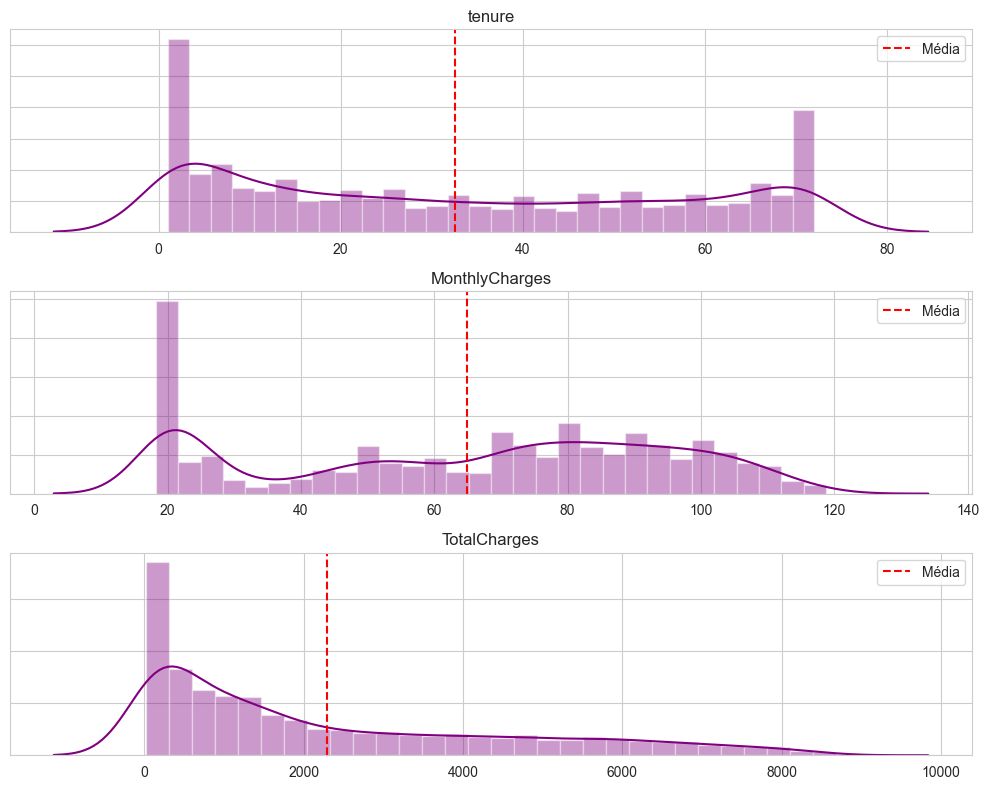

In [188]:
fig, axes = plt.subplots(3, 1, figsize = (10,8))

#índices dos subplots
count = range(3)

for var, ax in zip(numericas, count):
    sns.distplot(df[var], ax = axes[ax], bins = 30, color='purple').set(xlabel=None,
                                                                      ylabel=None,
                                                                      yticklabels=[])
    axes[ax].set_title(var)
    v = axes[ax].axvline(np.mean(df[var]), color='red', linestyle='--', label = 'Média')
    axes[ax].legend(handles=[v], labels=['Média'])

fig.tight_layout()

## 3.2. Variáveis categóricas

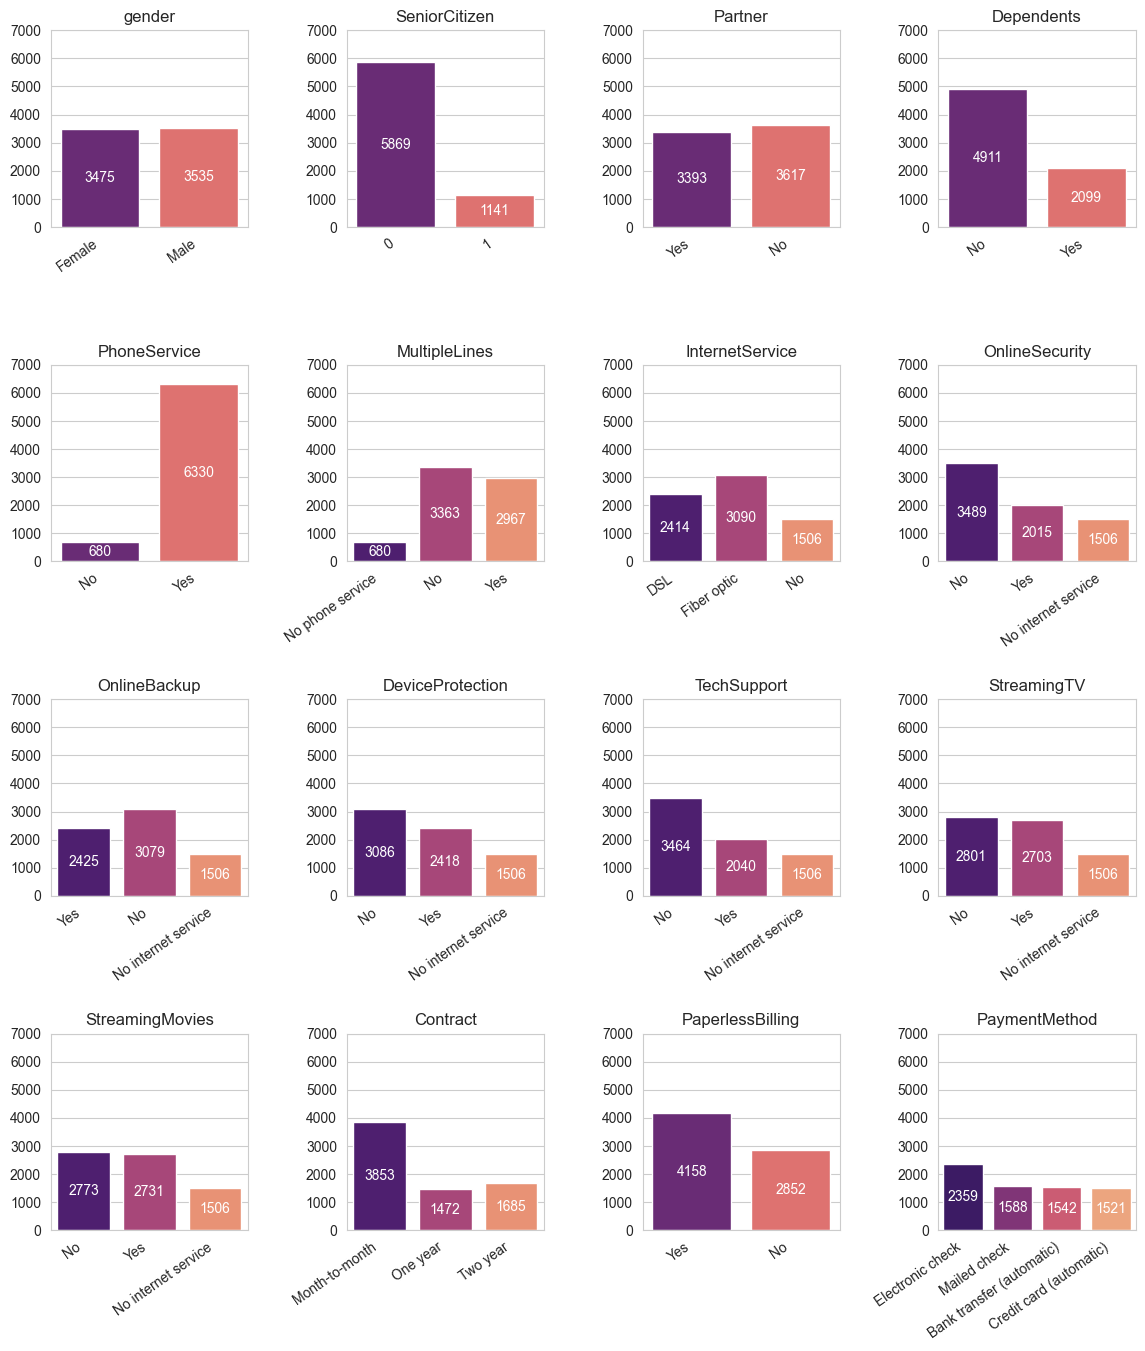

In [176]:
#Para as variáveis categóricas, checamos como está sua distribuição

fig, axes = plt.subplots(4, 4, figsize = (14, 15))

#índices dos subplots
count = list( product( list(range(4)), list(range(4)) ) )

for var, ax in zip(categoricas, count):
    sns.countplot(x = df[var], ax = axes[ax], palette = 'magma')
    
    axes[ax].set(title = var, xlabel=None, ylabel=None, ylim = [0, 7000])
    axes[ax].set_xticklabels(axes[ax].get_xticklabels(), rotation=35, ha='right')
    axes[ax].bar_label(axes[ax].containers[0], label_type='center', color='white')
 
plt.subplots_adjust(left=None, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.7)

Em uma primeira análise na distribuição de cada variável, podemos notar que a grande maioria dos clientes:

- Não são idosos
- Não possuem dependentes
- Possuem serviço de telefone

## Etapa 4 - Model/Modelagem

## Etapa 5 - Interpret/Interpretação